# Plant Disease Classification Model

This notebook shows the process of building a simple AI model to classify plant diseases from images. We will use a public dataset, preprocess the data, build a convolutional neural network (CNN), train and evaluate the model, and finally save it for use in an application.

**Note: Use T4 GPU for better performance :)**

## 1. Import Required Libraries

In [ ]:
!pip install tensorflow.keras # install tensorflow.keras since not available by default in colab's runtime

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# for colab downloads
from google.colab import files

## 2. Load and Explore Dataset
We will use the PlantVillage dataset, which is publically available through TensorFlow Datasets or TFDS. The dataset will be loaded directly using YFDS, be split into training, validation, and test sets using percentage-based slicing, and we will now explore its structure and visualize some sample images.

In [ ]:
dataset_name = 'plant_village'
(ds_train, ds_val, ds_test), ds_info = tfds.load (
    dataset_name,
    split = ['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised = True,
    with_info = True,
)

print('Classes: ', ds_info.features['label'].names)
print('Number of training samples: ', tf.data.experimental.cardinality(ds_train).numpy())
print('Number of validation samples: ', tf.data.experimental.cardinality(ds_val).numpy())
print('Number of test samples: ', tf.data.experimental.cardinality(ds_test).numpy())

Classes:  ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 

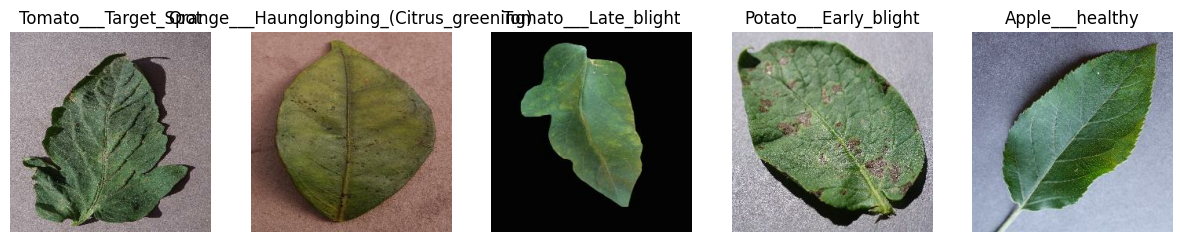

In [ ]:
# display some sample images
plt.figure(figsize=(15, 5))
for i, (image, label) in enumerate(ds_train.take(5)):
  plt.subplot(1, 5, i+1)
  plt.imshow(image)
  plt.title(ds_info.features['label'].int2str(label))
  plt.axis('off')
plt.show()

## 3. Preprocess the Data
We will preprocess the images by resizing them, normalizing pixel values, and applying data augmentation. The dataset is already split into training, validation, and test sets using TFDS percent-based slicing in the previous section, hence, splitting would no longer be done here. We'll also chech the number of samples in each split here, for reference.

In [ ]:
IMG_SIZE = (128,128)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# data augmentation for training
data_augmentation = keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


def preprocess_image(image, label, augment=False):
  image = tf.image.resize(image, IMG_SIZE)
  if augment:
    image = data_augmentation(image)
  else:
    image = tf.cast(image, tf.float32) / 255.0
  return image, label

train_ds = ds_train.map(lambda x, y: preprocess_image(x, y, augment=True), num_parallel_calls=AUTOTUNE)
val_ds = ds_val.map(lambda x, y: preprocess_image(x, y, augment=False), num_parallel_calls=AUTOTUNE)
test_ds = ds_test.map(lambda x, y: preprocess_image(x, y, augment=False), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names

# display the classes and their names
print(f'Number of classes: {num_classes}')
print(f'Class names: {class_names}')
print(f'Train set: {tf.data.experimental.cardinality(train_ds).numpy()} samples')
print(f'Validation set: {tf.data.experimental.cardinality(val_ds).numpy()} samples')
print(f'Test set: {tf.data.experimental.cardinality(test_ds).numpy()} samples')

Number of classes: 38
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato

# 4. Build the Model

We will define a simple CNN or convolutional neural network (CNN) using TensorFlow/Keras.

In [ ]:
model = keras.Sequential([
    layers.InputLayer(shape=(*IMG_SIZE, 3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,493,798 (32.40 MB)

 Trainable params: 8,492,838 (32.40 MB)

 Non-trainable params: 960 (3.75 KB)

## 6. Train the Model
We will now train the CNN model using the training set and validate on the validation set. Early stopping will be used, in order to prevent overfitting.

Epoch 1/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5755 - loss: 1.5896

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 192s 151ms/step - accuracy: 0.5756 - loss: 1.5891 - val_accuracy: 0.5773 - val_loss: 1.5649 - learning_rate: 0.0010
Epoch 2/40
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8243 - loss: 0.5679

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 179s 148ms/step - accuracy: 0.8243 - loss: 0.5678 - val_accuracy: 0.7999 - val_loss: 0.6574 - learning_rate: 0.0010
Epoch 3/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 175s 143ms/step - accuracy: 0.8744 - loss: 0.4031 - val_accuracy: 0.7564 - val_loss: 0.9513 - learning_rate: 0.0010
Epoch 4/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 201s 143ms/step - accuracy: 0.9077 - loss: 0.2886 - val_accuracy: 0.8080 - val_loss: 0.7024 - learning_rate: 0.0010
Epoch 5/40
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9230 - loss: 0.2364

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 175s 145ms/step - accuracy: 0.9230 - loss: 0.2364 - val_accuracy: 0.9411 - val_loss: 0.1713 - learning_rate: 0.0010
Epoch 6/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 173s 143ms/step - accuracy: 0.9350 - loss: 0.2046 - val_accuracy: 0.7649 - val_loss: 0.8510 - learning_rate: 0.0010
Epoch 7/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 206s 146ms/step - accuracy: 0.9416 - loss: 0.1811 - val_accuracy: 0.8205 - val_loss: 0.8275 - learning_rate: 0.0010
Epoch 8/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 181s 149ms/step - accuracy: 0.9471 - loss: 0.1599 - val_accuracy: 0.8308 - val_loss: 0.5655 - learning_rate: 0.0010
Epoch 9/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 174s 142ms/step - accuracy: 0.9621 - loss: 0.1151 - val_accuracy: 0.9322 - val_loss: 0.2901 - learning_rate: 2.0000e-04
Epoch 10/40
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9706 - loss: 0.0879

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 175s 144ms/step - accuracy: 0.9706 - loss: 0.0879 - val_accuracy: 0.9594 - val_loss: 0.1328 - learning_rate: 2.0000e-04
Epoch 11/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 202s 145ms/step - accuracy: 0.9748 - loss: 0.0760 - val_accuracy: 0.9471 - val_loss: 0.2061 - learning_rate: 2.0000e-04
Epoch 12/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 175s 144ms/step - accuracy: 0.9771 - loss: 0.0688 - val_accuracy: 0.9122 - val_loss: 0.4043 - learning_rate: 2.0000e-04
Epoch 13/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 201s 143ms/step - accuracy: 0.9787 - loss: 0.0637 - val_accuracy: 0.9508 - val_loss: 0.1519 - learning_rate: 2.0000e-04
Epoch 14/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 175s 144ms/step - accuracy: 0.9806 - loss: 0.0590 - val_accuracy: 0.9613 - val_loss: 0.1349 - learning_rate: 4.0000e-05
Epoch 15/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9826 - loss: 0.0528

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 207s 149ms/step - accuracy: 0.9826 - loss: 0.0528 - val_accuracy: 0.9661 - val_loss: 0.1093 - learning_rate: 4.0000e-05
Epoch 16/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 175s 144ms/step - accuracy: 0.9833 - loss: 0.0506 - val_accuracy: 0.9649 - val_loss: 0.1221 - learning_rate: 4.0000e-05
Epoch 17/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 174s 143ms/step - accuracy: 0.9854 - loss: 0.0464 - val_accuracy: 0.9612 - val_loss: 0.1373 - learning_rate: 4.0000e-05
Epoch 18/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9845 - loss: 0.0467

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 174s 142ms/step - accuracy: 0.9845 - loss: 0.0467 - val_accuracy: 0.9700 - val_loss: 0.0963 - learning_rate: 4.0000e-05
Epoch 19/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 206s 146ms/step - accuracy: 0.9855 - loss: 0.0442 - val_accuracy: 0.9628 - val_loss: 0.1296 - learning_rate: 4.0000e-05
Epoch 20/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 173s 142ms/step - accuracy: 0.9862 - loss: 0.0428 - val_accuracy: 0.9678 - val_loss: 0.1086 - learning_rate: 4.0000e-05
Epoch 21/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 173s 142ms/step - accuracy: 0.9869 - loss: 0.0416 - val_accuracy: 0.9628 - val_loss: 0.1365 - learning_rate: 4.0000e-05
Epoch 22/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 174s 143ms/step - accuracy: 0.9854 - loss: 0.0429 - val_accuracy: 0.9694 - val_loss: 0.0994 - learning_rate: 8.0000e-06
Epoch 23/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9868 - loss: 0.0407

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 174s 143ms/step - accuracy: 0.9868 - loss: 0.0407 - val_accuracy: 0.9704 - val_loss: 0.0939 - learning_rate: 8.0000e-06
Epoch 24/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 173s 142ms/step - accuracy: 0.9875 - loss: 0.0402 - val_accuracy: 0.9694 - val_loss: 0.0971 - learning_rate: 8.0000e-06
Epoch 25/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9869 - loss: 0.0404

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 173s 142ms/step - accuracy: 0.9869 - loss: 0.0404 - val_accuracy: 0.9702 - val_loss: 0.0930 - learning_rate: 8.0000e-06
Epoch 26/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 202s 143ms/step - accuracy: 0.9872 - loss: 0.0412 - val_accuracy: 0.9685 - val_loss: 0.1004 - learning_rate: 8.0000e-06
Epoch 27/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 174s 143ms/step - accuracy: 0.9859 - loss: 0.0440 - val_accuracy: 0.9698 - val_loss: 0.0966 - learning_rate: 8.0000e-06
Epoch 28/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 174s 143ms/step - accuracy: 0.9857 - loss: 0.0431 - val_accuracy: 0.9691 - val_loss: 0.0989 - learning_rate: 8.0000e-06
Epoch 29/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 179s 148ms/step - accuracy: 0.9843 - loss: 0.0440 - val_accuracy: 0.9704 - val_loss: 0.0948 - learning_rate: 1.6000e-06
Epoch 30/40
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 197s 143ms/step - accuracy: 0.9868 - loss: 0.0406 - val_accuracy: 0.9704 - val_loss: 0.0954 - learning_rate: 1.6000e-06
Epoch 31/40
1188/1188 ━━━━━━━━━━━━

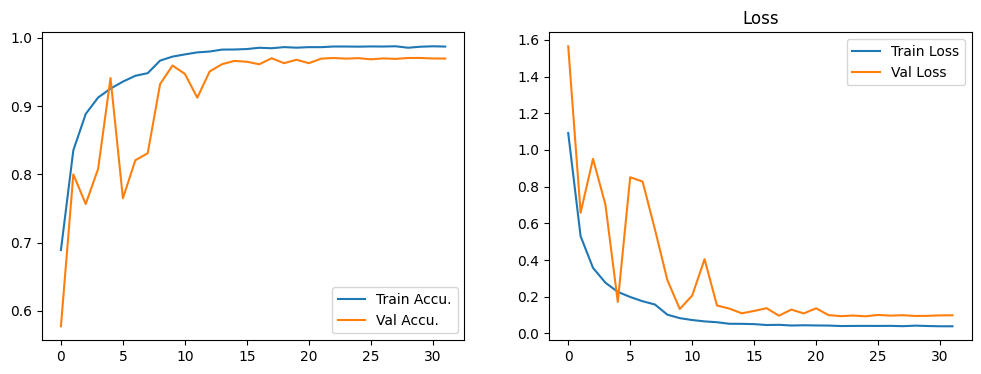

In [ ]:
checkpoint_cb = ModelCheckpoint('best_plant_disease_model.h5', save_best_only=True, monitor='val_loss')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_reduce]
)

# plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accu.')
plt.plot(history.history['val_accuracy'], label='Val Accu.')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

## 7. Evaluate the Model

We will now evaluate the trained model on the test set and visualize the results.

255/255 - 7s - 29ms/step - accuracy: 0.9759 - loss: 0.0777
Test accuracy: 0.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━

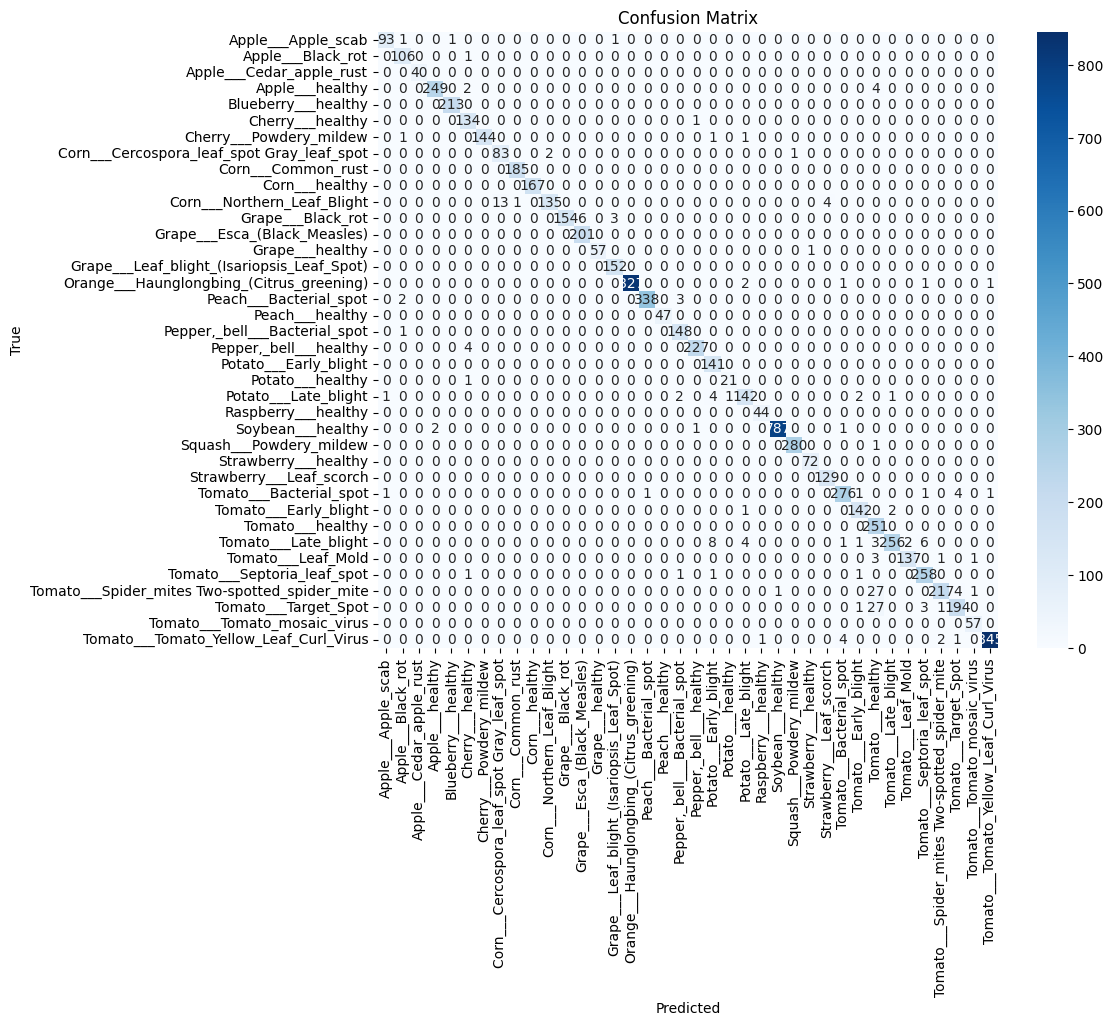

In [ ]:
# evaluate on test set
loss, accuracy = model.evaluate(test_ds, verbose=2)
print(f'Test accuracy: {accuracy:.2f}')

# predict and show confusion matrix
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 8. Save the Model
Although the .h5 file is already available in the codespace/files, we will save the traiend model (as .keras, as per recommendation since .h5 is deprecated) for later use in an application.

In [ ]:
# save the best model (already saved as best_plant_disease_model.h5 by ModelCheckpoint)

# save the final model in the new Keras format for deployment (.keras extension, as recommended by Keras 3)
model.save('plant_disease_model.keras')
print('Model also saved in Keras format as plant_disease_model.keras.')

Model also saved in Keras format as plant_disease_model.keras.


In [ ]:
# download the model files to your local machine
files.download('best_plant_disease_model.h5')
files.download('plant_disease_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry___healthy',
 'Cherry___Powdery_mildew',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___healthy',
 'Corn___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomat